In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Fri Feb  9 18:35:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
|  0%   54C    P8              61W / 200W |     11MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_vae_encoder import Encoder
from model.prior.normal_prior import Prior
from model.latent.dropout_vae_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.dropout_rate = 0.2
hp.activation = F.sigmoid


In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

dropout_rate : 0.2
encoder 7.9921875
encoder.convs 5.9912109375
encoder.linear 2.0009765625
prior 0.0
latent 0.0
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_celeba/train02.09-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/home/scpark/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

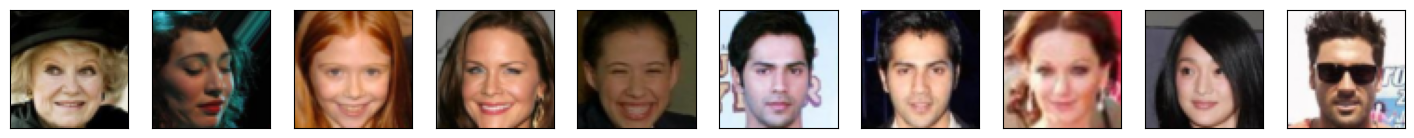

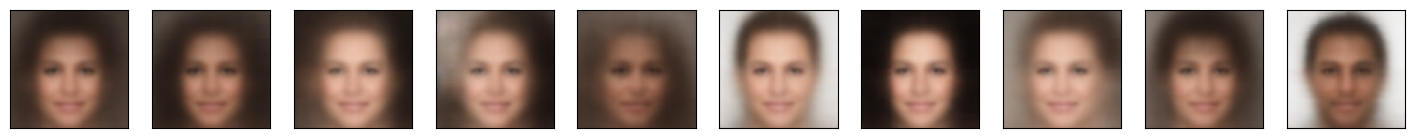

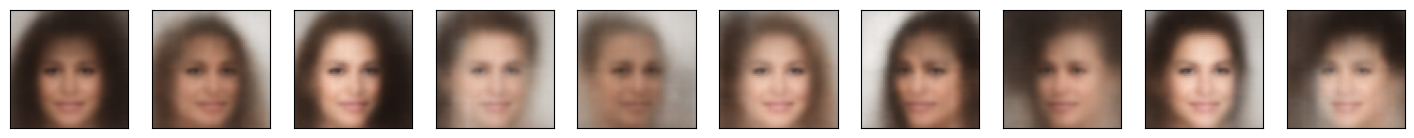

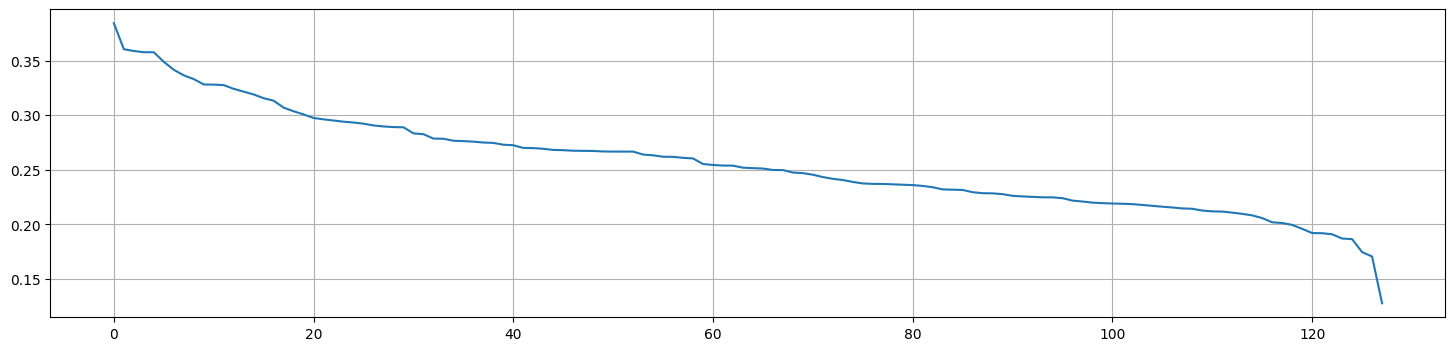

3001
kl_loss 30.77069664001465
recon_loss 0.03555002808570862
3002
kl_loss 31.235977172851562
recon_loss 0.036203064024448395
3003
kl_loss 31.932926177978516
recon_loss 0.035849254578351974
3004
kl_loss 31.622455596923828
recon_loss 0.03508371114730835
3005
kl_loss 30.397523880004883
recon_loss 0.03582536801695824
3006
kl_loss 31.98680877685547
recon_loss 0.036164574325084686
3007
kl_loss 31.11334228515625
recon_loss 0.03275633603334427
3008
kl_loss 32.51246643066406
recon_loss 0.03451937064528465
3009
kl_loss 31.86323356628418
recon_loss 0.03558669239282608
3010
kl_loss 32.340232849121094
recon_loss 0.03353843092918396
3011
kl_loss 31.180564880371094
recon_loss 0.03429801017045975
3012
kl_loss 33.037078857421875
recon_loss 0.03599648177623749
3013
kl_loss 33.252052307128906
recon_loss 0.035114552825689316
3014
kl_loss 32.50446319580078
recon_loss 0.03732055425643921
3015
kl_loss 33.73859405517578
recon_loss 0.03321627154946327
3016
kl_loss 32.08824157714844
recon_loss 0.03601483255624

3132
kl_loss 30.87858009338379
recon_loss 0.03426773473620415
3133
kl_loss 33.35282516479492
recon_loss 0.03263009339570999
3134
kl_loss 32.064395904541016
recon_loss 0.03482770919799805
3135
kl_loss 32.9672737121582
recon_loss 0.03364824131131172
3136
kl_loss 32.09636688232422
recon_loss 0.03455255553126335
3137
kl_loss 32.17839050292969
recon_loss 0.03659343346953392
3138
kl_loss 32.3355598449707
recon_loss 0.03412735089659691
3139
kl_loss 31.971885681152344
recon_loss 0.03610679879784584
3140
kl_loss 31.877090454101562
recon_loss 0.036057718098163605
3141
kl_loss 33.62898635864258
recon_loss 0.03545653074979782
3142
kl_loss 32.385032653808594
recon_loss 0.03654877096414566
3143
kl_loss 32.700645446777344
recon_loss 0.034014992415905
3144
kl_loss 33.081966400146484
recon_loss 0.03528042882680893
3145
kl_loss 35.33820343017578
recon_loss 0.03276856243610382
3146
kl_loss 32.999534606933594
recon_loss 0.03449822589755058
3147
kl_loss 32.82999801635742
recon_loss 0.0368424654006958
3148


3264
kl_loss 33.30183792114258
recon_loss 0.034943222999572754
3265
kl_loss 34.08525085449219
recon_loss 0.035219769924879074
3266
kl_loss 32.191890716552734
recon_loss 0.03404182940721512
3267
kl_loss 32.757225036621094
recon_loss 0.03443001210689545
3268
kl_loss 36.615196228027344
recon_loss 0.03479069471359253
3269
kl_loss 32.663963317871094
recon_loss 0.03456973657011986
3270
kl_loss 32.33945083618164
recon_loss 0.034320905804634094
3271
kl_loss 34.14344787597656
recon_loss 0.03661245107650757
3272
kl_loss 32.01469039916992
recon_loss 0.03425587713718414
3273
kl_loss 33.61125183105469
recon_loss 0.03418868035078049
3274
kl_loss 33.20624542236328
recon_loss 0.035258643329143524
3275
kl_loss 32.98953628540039
recon_loss 0.03291098028421402
3276
kl_loss 33.78269577026367
recon_loss 0.03428332507610321
3277
kl_loss 32.33429718017578
recon_loss 0.03457813337445259
3278
kl_loss 33.15338134765625
recon_loss 0.035900093615055084
3279
kl_loss 32.69364929199219
recon_loss 0.03562106192111969

kl_loss 34.49888610839844
recon_loss 0.035411007702350616
3396
kl_loss 33.69651794433594
recon_loss 0.03295287489891052
3397
kl_loss 32.680057525634766
recon_loss 0.03403916209936142
3398
kl_loss 33.13047790527344
recon_loss 0.033948831260204315
3399
kl_loss 32.86809539794922
recon_loss 0.03579171746969223
3400
kl_loss 32.89578628540039
recon_loss 0.03486910089850426
3401
kl_loss 34.18115997314453
recon_loss 0.033632323145866394
3402
kl_loss 33.045196533203125
recon_loss 0.035879626870155334
3403
kl_loss 32.51399230957031
recon_loss 0.03445039317011833
3404
kl_loss 32.44072723388672
recon_loss 0.03556710109114647
3405
kl_loss 32.807861328125
recon_loss 0.034742459654808044
3406
kl_loss 34.4292106628418
recon_loss 0.03495357930660248
3407
kl_loss 32.18894958496094
recon_loss 0.034823790192604065
3408
kl_loss 32.21845245361328
recon_loss 0.03521377965807915
3409
kl_loss 32.747398376464844
recon_loss 0.033143118023872375
3410
kl_loss 32.65774154663086
recon_loss 0.034606896340847015
3411


3526
kl_loss 31.798498153686523
recon_loss 0.03590046241879463
3527
kl_loss 33.37088394165039
recon_loss 0.03677844628691673
3528
kl_loss 31.80612564086914
recon_loss 0.035061150789260864
3529
kl_loss 34.39734649658203
recon_loss 0.03511810302734375
3530
kl_loss 32.779808044433594
recon_loss 0.03425423428416252
3531
kl_loss 33.59220886230469
recon_loss 0.034825049340724945
3532
kl_loss 34.475807189941406
recon_loss 0.0342949703335762
3533
kl_loss 31.597557067871094
recon_loss 0.03546319529414177
3534
kl_loss 34.012718200683594
recon_loss 0.03304954618215561
3535
kl_loss 33.468109130859375
recon_loss 0.03591899573802948
3536
kl_loss 31.809850692749023
recon_loss 0.03414802998304367
3537
kl_loss 33.6178092956543
recon_loss 0.03391418606042862
3538
kl_loss 30.900699615478516
recon_loss 0.03575855493545532
3539
kl_loss 31.364046096801758
recon_loss 0.03407978639006615
3540
kl_loss 32.09949493408203
recon_loss 0.034567154943943024
3541
kl_loss 32.712562561035156
recon_loss 0.036717213690280

3659
kl_loss 32.54498291015625
recon_loss 0.03570165857672691
3660
kl_loss 32.70597839355469
recon_loss 0.0349913015961647
3661
kl_loss 32.447914123535156
recon_loss 0.03411807864904404
3662
kl_loss 32.25836944580078
recon_loss 0.03514137864112854
3663
kl_loss 31.41876983642578
recon_loss 0.035044893622398376
3664
kl_loss 33.026222229003906
recon_loss 0.03437834978103638
3665
kl_loss 30.695480346679688
recon_loss 0.03558427095413208
3666
kl_loss 32.28205871582031
recon_loss 0.03546273335814476
3667
kl_loss 32.738739013671875
recon_loss 0.03666624054312706
3668
kl_loss 31.373966217041016
recon_loss 0.03556966036558151
3669
kl_loss 33.05690002441406
recon_loss 0.03485938534140587
3670
kl_loss 32.043121337890625
recon_loss 0.03536830469965935
3671
kl_loss 33.18105697631836
recon_loss 0.03478079289197922
3672
kl_loss 33.921485900878906
recon_loss 0.03714277967810631
3673
kl_loss 33.56500244140625
recon_loss 0.03543110191822052
3674
kl_loss 33.762611389160156
recon_loss 0.03570127487182617


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fe0e8032e10>>
Traceback (most recent call last):
  File "/home/scpark/anaconda3/envs/ste/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


3719
kl_loss 32.05342483520508
recon_loss 0.034625910222530365



KeyboardInterrupt



In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=1024)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=1024)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            kls = torch.sort(data['kl'].mean(dim=0), descending=True).values.data.cpu().numpy()
            plt.figure(figsize=[18, 4])
            plt.plot(kls)
            plt.grid()
            plt.show()    
                
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [11]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done
